In [1]:
# 사용할 모듈 불러오기 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re


In [2]:
# 데이터 불러오기
items = pd.read_csv("./items.csv")
shops = pd.read_csv("./shops.csv")
train = pd.read_csv("./sales_train.csv")
test = pd.read_csv("./test.csv")
item_categories = pd.read_csv('./item_categories.csv')

# EDA

## Train
###  columns 뜻
 - data  = 날짜
 - date_block_num  = 한달 단위로 구분하기 편하게 하기 위한 데이터
 - shop_id = 가게 id
 - item_price = 아이템 가격
 - item_cnt_day = 당일 해당 아이템이 팔린 개수

In [3]:
train.info() # null 값이 모든데이터에 존재 하지 않는다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [4]:
#  date의 자료형을 object  -> dattime 으로 바꾸고 싶다. 
# 변환하는 과정  ->
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")
train["date"]. head(3) 

0   2013-01-02
1   2013-01-03
2   2013-01-05
Name: date, dtype: datetime64[ns]

In [5]:
train.describe(include = 'all')

/var/folders/n4/tlr0x9b97v3bzyh49yfs3ps00000gn/T/ipykernel_2161/2740853986.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train.describe(include = 'all')


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
unique,1034,NaN,NaN,NaN,NaN,NaN
top,2013-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN
freq,9434,NaN,NaN,NaN,NaN,NaN
first,2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2015-10-31 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,NaN,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,NaN,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00


2013-01-01 00:00:00 ~ 2015-10-31 00:00:00  까지의 1034일간의 데이터임을 알수있다.  
item_price은 평균과 중위값의 차이가 심한 것으로 보아 이상치가 존재함을 알 수 있디.  
item_cnt_day 는일,이,삼 분위수가 1인데 비해 평균은 대략 1.2  최대값은 2168로 이상치가 존재한다.   
item_cnt_day, item_price에 최소값들은 음수이다.  

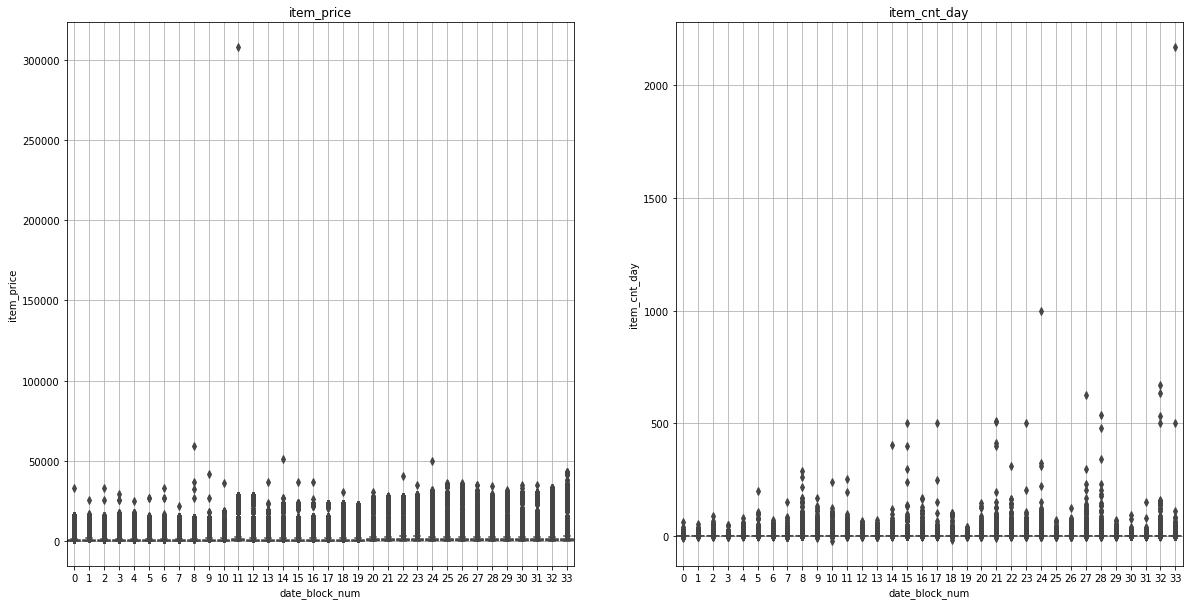

In [6]:
def price_cntday_boxplot():
    plt.figure(figsize = (20,10))
    # item_price 의 박스플롯
    plt.subplot(1,2,1)
    sns.boxplot(x = 'date_block_num' , y= 'item_price',data =train)
    plt.title('item_price')
    plt.grid()
    # item_cnt_day의 박스 플롯
    plt.subplot(1,2,2)
    sns.boxplot(x = 'date_block_num' , y= 'item_cnt_day',data =train)
    plt.title('item_cnt_day')
    plt.grid()
price_cntday_boxplot()

- 다음은 date_block_num 별로 item_price의 boxplot이다.  
- 위의 그래프를 기준으로 item_price는 50000 이상 , item_cnt_day 는 1000 이상을 이상치로서 train에서 제거한다.  
- 또한 판매되는 수량을 구하는 것이 목적이므로 0미만의 값을 제거한다.

In [7]:
condition_for_drop = ((train["item_price"] >= 50000) | (train["item_price"] < 0))
train.drop(train[condition_for_drop].index, axis = 0 , inplace=True)

condition_for_drop = ((train["item_cnt_day"] >= 1000) | (train["item_cnt_day"] < 0))
train.drop(train[condition_for_drop].index, axis = 0 , inplace=True)

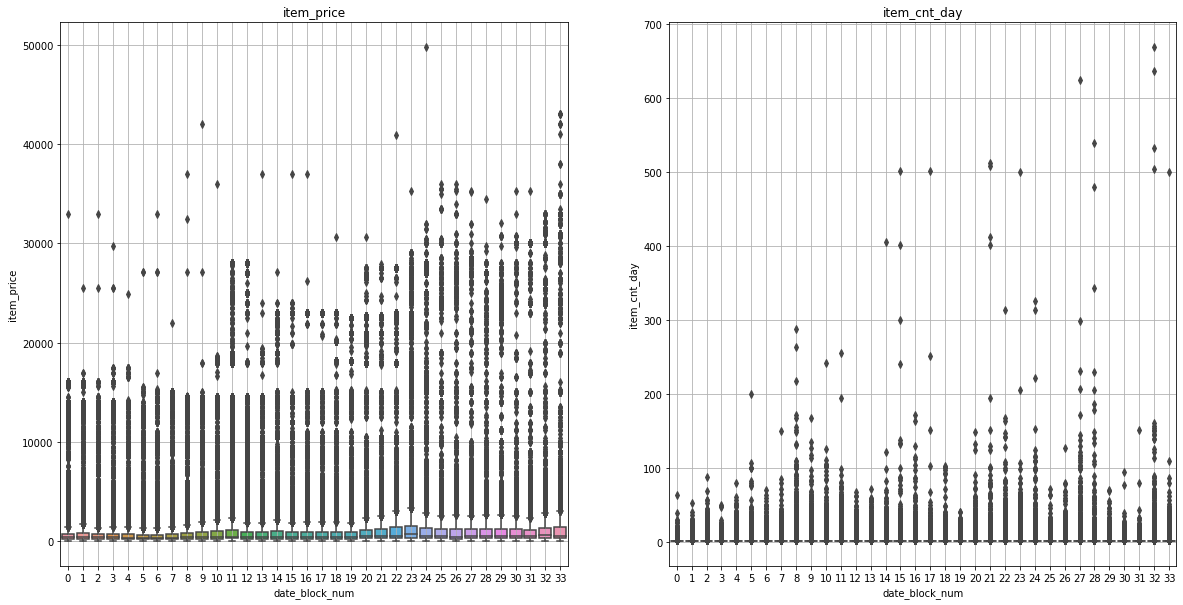

In [8]:
# 제거 후의 boxplot
price_cntday_boxplot()

In [9]:
train.corr()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019329,0.009472,0.095539,0.010339
shop_id,0.019329,1.000000,0.029345,-0.023955,-0.005660
item_id,0.009472,0.029345,1.000000,-0.134812,0.018896
item_price,0.095539,-0.023955,-0.134812,1.000000,0.014444
item_cnt_day,0.010339,-0.005660,0.018896,0.014444,1.000000


## shops

In [10]:
shops.info() # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [11]:
shops.head(20)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


- 이름에 특수문자가 들어가고 중복되는 이름들이 보인다

In [12]:
def clean_text(inputString):
    text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', inputString)
    return text_rmv
shops_names = shops["shop_name"].apply(clean_text)
shops_id = shops["shop_id"]
# 중복되는 이름 확인 
for i in list(zip(shops_names ,shops_id)):
    for j in list(zip(shops_names ,shops_id)):
        if (re.match('.*'+i[0]+'*.',j[0])) and (i[1]!= j[1]):
            print('code : ', i[1], ' and  ', j[1])
            print('name : ', i[0], ' and  ', j[0])
            

code :  10  and   11
name :  Жуковский ул  Чкалова 39м   and   Жуковский ул  Чкалова 39м²
code :  11  and   10
name :  Жуковский ул  Чкалова 39м²  and   Жуковский ул  Чкалова 39м 
code :  39  and   40
name :  РостовНаДону ТРК  Мегацентр Горизонт   and   РостовНаДону ТРК  Мегацентр Горизонт  Островной
code :  57  and   0
name :  Якутск Орджоникидзе  56  and    Якутск Орджоникидзе  56 фран
code :  58  and   1
name :  Якутск ТЦ  Центральный   and    Якутск ТЦ  Центральный  фран


- 위와 같이 shop id가 10:11, 39:40, 57:0, 58:1 4개의 아이디가 중복되는 것을 알 수 있다.
- 위의 데이터를 기준으로 train data의 shop id를 바꾸어준다

In [13]:
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})

## items

In [14]:
items.info() # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [15]:
items.head(20) # 이름에 특수 문자 제거 후 비슷한 게임끼리 

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


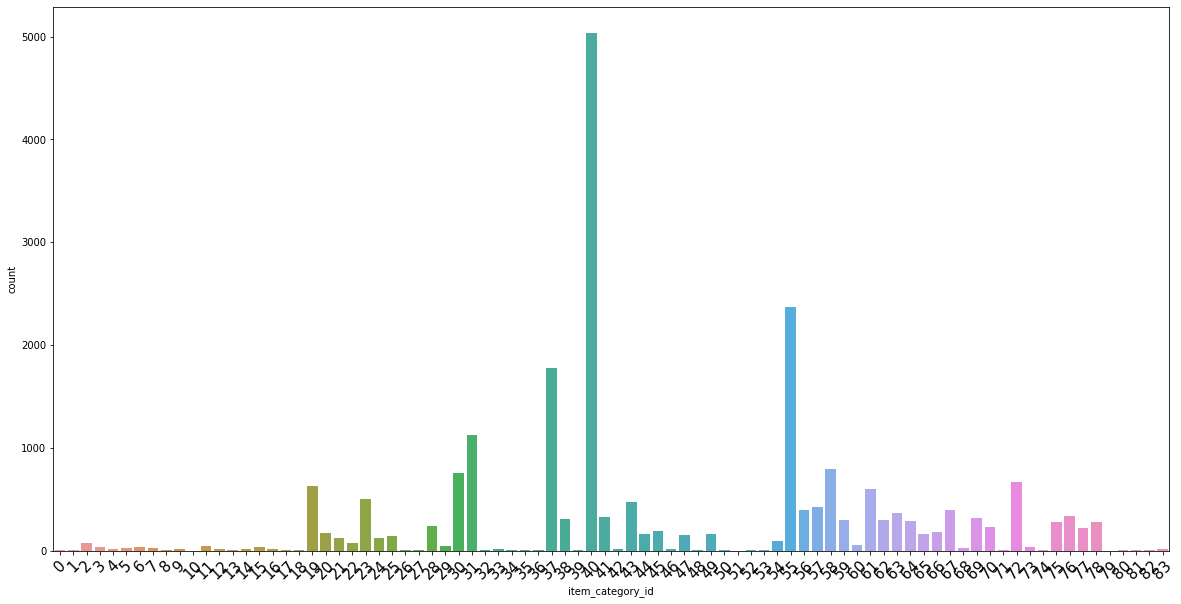

In [16]:
plt.figure(figsize=(20,10))
sns.countplot(x= 'item_category_id' , data = items)
plt.xticks(size = 15 , rotation =  45 , color = 'black')
plt.show()

In [17]:
item_categories[item_categories['item_category_id']==40]

,item_category_name,item_category_id
40,Кино - DVD,40


- item_category_id =40 인  Кино - DVD 카테고리에 많은 아이템이 존재하는지 알 수 있다

## item_category

In [18]:
item_categories.info()  # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [19]:
item_categories.head(20)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


- item_category_name에 같은 단어가 들어가는 데이터가 많이 존재한다
- 이를 묶어 더 큰 범주를 만들 수 있다.

## test

In [20]:
test.info()  # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [21]:
# test의 shop_id , item_id 기 train 데이터에 있는지 확인
diff_test_train_shopid = set(test['shop_id']) - set(train['shop_id'])
print('diffrent shop_id nums: ',len(diff_test_train_shopid))
diff_test_train_itemid = set(test['item_id']) - set(train['item_id'])
print('diffrent item_id nums: ',len(diff_test_train_itemid))
diff_test_items_itemid = set(test['item_id']) - set(items['item_id'])
print('diff_test_items_itemid nums: ',len(diff_test_items_itemid))

diffrent shop_id nums:  0
diffrent item_id nums:  363
diff_test_items_itemid nums:  0


#### test에는 존재하지만 train에 존재하지 않는 값이 363개 존재한다. 
#### items에는 test에 있는 모든 item_id를 가지고 있다. 
#### 이를 해결하기위해 다음과 같은 방법을 사용한다
 - train에 존재하지 않는 test값을 예측하기 위해 item_category_id를 사용한다.

item_category의 앞부분만 자르고 새롭게 만든 열을 라벨인코딩 (악세사리 >> 1)   
item_id와 연결되어있는 item_category를 새롭게 만든 열로 연결하여 test값을 예측한다면?

In [22]:
# item_category 분류하여 새로운 열 만들기
high_categories = item_categories.item_category_name

In [23]:
'''
Игры Android 등 '-' 뿐만 아니라 ' ' 기준으로 나누어져야 합니다. 
'''

high_categories.str.split('-').str[0].unique()

array(['PC ', 'Аксессуары ', 'Билеты (Цифра)', 'Доставка товара',
       'Игровые консоли ', 'Игры ', 'Игры Android ', 'Игры MAC ',
       'Игры PC ', 'Карты оплаты (Кино, Музыка, Игры)', 'Карты оплаты ',
       'Кино ', 'Книги ', 'Музыка ', 'Подарки ', 'Программы ',
       'Служебные', 'Служебные ', 'Чистые носители (шпиль)',
       'Чистые носители (штучные)', 'Элементы питания'], dtype=object)

In [24]:
high_categories

0       PC - Гарнитуры/Наушники
1              Аксессуары - PS2
2              Аксессуары - PS3
3              Аксессуары - PS4
4              Аксессуары - PSP
                ...            
79                    Служебные
80           Служебные - Билеты
81      Чистые носители (шпиль)
82    Чистые носители (штучные)
83             Элементы питания
Name: item_category_name, Length: 84, dtype: object

In [25]:
'''
위에서 만든 특수문자 제거 함수 사용
'''
high_categories = high_categories.apply(clean_text)
high_categories

0       PC   Гарнитуры Наушники
1              Аксессуары   PS2
2              Аксессуары   PS3
3              Аксессуары   PS4
4              Аксессуары   PSP
                ...            
79                    Служебные
80           Служебные   Билеты
81      Чистые носители  шпиль 
82    Чистые носители  штучные 
83             Элементы питания
Name: item_category_name, Length: 84, dtype: object

In [26]:
'''
공백으로 문자 분리하기
'''
high_categories = high_categories.str.split(' ')
high_categories

0       [PC, , , Гарнитуры, Наушники]
1               [Аксессуары, , , PS2]
2               [Аксессуары, , , PS3]
3               [Аксессуары, , , PS4]
4               [Аксессуары, , , PSP]
                   ...               
79                        [Служебные]
80            [Служебные, , , Билеты]
81      [Чистые, носители, , шпиль, ]
82    [Чистые, носители, , штучные, ]
83                [Элементы, питания]
Name: item_category_name, Length: 84, dtype: object

In [27]:
'''
앞에 문자만 분리해서 저장
'''
high_categories = [high_categories[i][0] for i in range(len(high_categories))]
high_categories

['PC',
 'Аксессуары',
 'Аксессуары',
 'Аксессуары',
 'Аксессуары',
 'Аксессуары',
 'Аксессуары',
 'Аксессуары',
 'Билеты',
 'Доставка',
 'Игровые',
 'Игровые',
 'Игровые',
 'Игровые',
 'Игровые',
 'Игровые',
 'Игровые',
 'Игровые',
 'Игры',
 'Игры',
 'Игры',
 'Игры',
 'Игры',
 'Игры',
 'Игры',
 'Игры',
 'Игры',
 'Игры',
 'Игры',
 'Игры',
 'Игры',
 'Игры',
 'Карты',
 'Карты',
 'Карты',
 'Карты',
 'Карты',
 'Кино',
 'Кино',
 'Кино',
 'Кино',
 'Кино',
 'Книги',
 'Книги',
 'Книги',
 'Книги',
 'Книги',
 'Книги',
 'Книги',
 'Книги',
 'Книги',
 'Книги',
 'Книги',
 'Книги',
 'Книги',
 'Музыка',
 'Музыка',
 'Музыка',
 'Музыка',
 'Музыка',
 'Музыка',
 'Подарки',
 'Подарки',
 'Подарки',
 'Подарки',
 'Подарки',
 'Подарки',
 'Подарки',
 'Подарки',
 'Подарки',
 'Подарки',
 'Подарки',
 'Подарки',
 'Программы',
 'Программы',
 'Программы',
 'Программы',
 'Программы',
 'Программы',
 'Служебные',
 'Служебные',
 'Чистые',
 'Чистые',
 'Элементы']

In [28]:
item_high_categories = item_categories.copy()
item_high_categories['high_categories'] = high_categories

In [29]:
'''
완성 이것을 라벨 인코딩하면 될 것 같습니다. 
'''
item_high_categories

,item_category_name,item_category_id,high_categories
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
...,...,...,...
79,Служебные,79,Служебные
80,Служебные - Билеты,80,Служебные
81,Чистые носители (шпиль),81,Чистые
82,Чистые носители (штучные),82,Чистые


In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [44]:
le.fit_transform(item_high_categories['item_category_name'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])

In [45]:
# le.fit_transform(item_high_categories['item_category_name']).value_counts()

In [46]:
# le.fit_transform(item_high_categories['high_categories']).value_counts()

In [47]:
le.fit_transform(item_high_categories['high_categories'])

array([ 0,  1,  1,  1,  1,  1,  1,  1,  2,  3,  4,  4,  4,  4,  4,  4,  4,
        4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,
        6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 13, 13, 14])

In [48]:
item_high_categories['high_categories'].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: high_categories, dtype: int64

In [49]:
# item_high_categories['item_category_name'] = le.fit_transform(item_high_categories['item_category_name'])

In [50]:
# item_high_categories['item_category_id'] = le.fit_transform(item_high_categories['item_category_id'])

In [51]:
# item_high_categories['high_categories'] = le.fit_transform(item_high_categories['high_categories'])

In [52]:
# item_high_categories['high_categories'].value_counts()

In [53]:
# item_high_categories['high_categories']

In [57]:
def make_high_category(categories_series):
    cat = categories_series
    cat = cat.apply(clean_text)
    cat = cat.str.split(' ')
    cat = [data[1] if data[0] == '' else data[0] for data in cat]
    high_cat_le = LabelEncoder()
    high_cat_le.fit(cat)
    cat_id = high_cat_le.transform(cat)
    return cat , cat_id, high_cat_le

In [60]:
shops['city'],shops['city_id'],shops_le = make_high_category(shops.shop_name)

In [122]:
item_high_categories['item'],item_high_categories['item_high_category'],item_high_categories_le = make_high_category(item_high_categories.item_category_name)

In [126]:
item_high_categories = item_high_categories.drop(['item_id'],axis = 1)

In [127]:
item_high_categories

,item_category_name,item_category_id,high_categories,item,item_high_category
0,PC - Гарнитуры/Наушники,0,PC,PC,0
1,Аксессуары - PS2,1,Аксессуары,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,Аксессуары,1
3,Аксессуары - PS4,3,Аксессуары,Аксессуары,1
4,Аксессуары - PSP,4,Аксессуары,Аксессуары,1
...,...,...,...,...,...
79,Служебные,79,Служебные,Служебные,12
80,Служебные - Билеты,80,Служебные,Служебные,12
81,Чистые носители (шпиль),81,Чистые,Чистые,13
82,Чистые носители (штучные),82,Чистые,Чистые,13


In [61]:
shops.head()

,shop_name,shop_id,city,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [ ]:
#items_test_merge = pd.merge(items,test, 
#                            left_on = ['item_id'], right_on = ['item_id'])

In [71]:
shops_train = pd.merge(shops,train)

In [72]:
item_high_categories

,item_category_name,item_category_id,high_categories
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
...,...,...,...
79,Служебные,79,Служебные
80,Служебные - Билеты,80,Служебные
81,Чистые носители (шпиль),81,Чистые
82,Чистые носители (штучные),82,Чистые


In [70]:
pd.concat([shops_train,item_high_categories],axis = 1)

,shop_name,shop_id,city,city_id,date,date_block_num,item_id,item_price,item_cnt_day,item_category_name,item_category_id,high_categories
0,"Адыгея ТЦ ""Мега""",2,Адыгея,0,2013-01-14,0,11330,149.0,1.0,PC - Гарнитуры/Наушники,0.0,PC
1,"Адыгея ТЦ ""Мега""",2,Адыгея,0,2013-01-14,0,11331,149.0,1.0,Аксессуары - PS2,1.0,Аксессуары
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0,2013-01-14,0,11332,149.0,1.0,Аксессуары - PS3,2.0,Аксессуары
3,"Адыгея ТЦ ""Мега""",2,Адыгея,0,2013-01-11,0,11015,199.0,1.0,Аксессуары - PS4,3.0,Аксессуары
4,"Адыгея ТЦ ""Мега""",2,Адыгея,0,2013-01-07,0,11030,149.0,1.0,Аксессуары - PSP,4.0,Аксессуары
...,...,...,...,...,...,...,...,...,...,...,...,...
2928482,"Ярославль ТЦ ""Альтаир""",59,Ярославль,30,2015-10-10,33,4962,298.0,1.0,NaN,NaN,NaN
2928483,"Ярославль ТЦ ""Альтаир""",59,Ярославль,30,2015-10-04,33,4706,299.0,1.0,NaN,NaN,NaN
2928484,"Ярославль ТЦ ""Альтаир""",59,Ярославль,30,2015-10-11,33,5002,2999.0,1.0,NaN,NaN,NaN
2928485,"Ярославль ТЦ ""Альтаир""",59,Ярославль,30,2015-10-15,33,5233,1199.0,1.0,NaN,NaN,NaN


In [73]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [74]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [78]:
test_train = pd.merge(test,train)
test_train

,ID,shop_id,item_id,date,date_block_num,item_price,item_cnt_day
0,0,5,5037,2014-09-21,20,2599.0,1.0
1,0,5,5037,2014-11-29,22,2599.0,1.0
2,0,5,5037,2014-12-28,23,1999.0,1.0
3,0,5,5037,2014-12-20,23,1999.0,1.0
4,0,5,5037,2015-01-02,24,1999.0,1.0
...,...,...,...,...,...,...,...
1227953,214197,45,15757,2015-02-22,25,199.0,1.0
1227954,214199,45,969,2014-06-22,17,549.0,1.0
1227955,214199,45,969,2014-06-28,17,549.0,2.0
1227956,214199,45,969,2014-07-11,18,549.0,1.0


In [150]:
#양던
test['date_block_num'] = 34
test['item_price'] = 1
test['item_cnt_day'] = 0
test['item_revenue_days'] = 0 

In [151]:
#양던
train_test = pd.concat([train,test],axis = 0 , join = 'outer').sort_values('date_block_num').reset_index().drop('index' ,axis = 1)

In [152]:
# 시티아이디 하이카테고리 아이디 머징

In [153]:
train_test

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,ID,item_revenue_days
0,2013-01-02,0,59,22154,999.0,1.0,NaN,NaN
1,2013-01-02,0,54,18616,349.0,1.0,NaN,NaN
2,2013-01-11,0,54,18613,149.0,1.0,NaN,NaN
3,2013-01-07,0,54,18613,149.0,1.0,NaN,NaN
4,2013-01-27,0,54,18608,199.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...
3142682,NaT,34,21,5232,1.0,0.0,71403.0,0.0
3142683,NaT,34,21,5268,1.0,0.0,71404.0,0.0
3142684,NaT,34,21,5039,1.0,0.0,71405.0,0.0
3142685,NaT,34,21,5672,1.0,0.0,71433.0,0.0


In [154]:
shops

,shop_name,shop_id,city,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,3
6,"Воронеж (Плехановская, 13)",6,Воронеж,4
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,4
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,4
9,Выездная Торговля,9,Выездная,5


In [155]:
train_test_shops = pd.merge(train_test,shops)

In [156]:
train_test_shops

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,ID,item_revenue_days,shop_name,city,city_id
0,2013-01-02,0,59,22154,999.0,1.0,NaN,NaN,"Ярославль ТЦ ""Альтаир""",Ярославль,30
1,2013-01-14,0,59,5574,699.0,1.0,NaN,NaN,"Ярославль ТЦ ""Альтаир""",Ярославль,30
2,2013-01-04,0,59,5574,699.0,2.0,NaN,NaN,"Ярославль ТЦ ""Альтаир""",Ярославль,30
3,2013-01-22,0,59,5573,999.0,1.0,NaN,NaN,"Ярославль ТЦ ""Альтаир""",Ярославль,30
4,2013-01-24,0,59,5572,1590.0,1.0,NaN,NaN,"Ярославль ТЦ ""Альтаир""",Ярославль,30
...,...,...,...,...,...,...,...,...,...,...,...
3142682,NaT,34,36,6861,1.0,0.0,165115.0,0.0,"Новосибирск ТРЦ ""Галерея Новосибирск""",Новосибирск,16
3142683,NaT,34,36,6996,1.0,0.0,165116.0,0.0,"Новосибирск ТРЦ ""Галерея Новосибирск""",Новосибирск,16
3142684,NaT,34,36,7524,1.0,0.0,165117.0,0.0,"Новосибирск ТРЦ ""Галерея Новосибирск""",Новосибирск,16
3142685,NaT,34,36,7730,1.0,0.0,165118.0,0.0,"Новосибирск ТРЦ ""Галерея Новосибирск""",Новосибирск,16


In [157]:
item_finish = pd.merge(items, item_high_categories)

In [158]:
len(items)

22170

In [159]:
item_finish

,item_name,item_id,item_category_id,item_category_name,high_categories,item,item_high_category
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,Кино,7
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,Кино,7
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,Кино,7
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,Кино,7
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,Кино,7
...,...,...,...,...,...,...,...
22165,Элемент питания GP 15AU (LR6) - Блистер 2 шт U...,22095,83,Элементы питания,Элементы,Элементы,14
22166,Элемент питания GP 24A (LR03) - Блистер 2 шт,22096,83,Элементы питания,Элементы,Элементы,14
22167,Элемент питания GP 24AU (LR03) - Блистер 2 шт ...,22097,83,Элементы питания,Элементы,Элементы,14
22168,Элемент питания КОСМОС LR03 2*BL,22098,83,Элементы питания,Элементы,Элементы,14


In [160]:
item_finish = item_finish.drop(['item_name','item_category_name','high_categories','item'],axis = 1)

In [161]:
item_finish

,item_id,item_category_id,item_high_category
0,0,40,7
1,2,40,7
2,3,40,7
3,4,40,7
4,5,40,7
...,...,...,...
22165,22095,83,14
22166,22096,83,14
22167,22097,83,14
22168,22098,83,14


In [162]:
train_test_shops['item_revenue_days'] = train_test_shops['item_cnt_day']*train_test_shops['item_price']

In [163]:
train_test_shops

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,ID,item_revenue_days,shop_name,city,city_id
0,2013-01-02,0,59,22154,999.0,1.0,NaN,999.0,"Ярославль ТЦ ""Альтаир""",Ярославль,30
1,2013-01-14,0,59,5574,699.0,1.0,NaN,699.0,"Ярославль ТЦ ""Альтаир""",Ярославль,30
2,2013-01-04,0,59,5574,699.0,2.0,NaN,1398.0,"Ярославль ТЦ ""Альтаир""",Ярославль,30
3,2013-01-22,0,59,5573,999.0,1.0,NaN,999.0,"Ярославль ТЦ ""Альтаир""",Ярославль,30
4,2013-01-24,0,59,5572,1590.0,1.0,NaN,1590.0,"Ярославль ТЦ ""Альтаир""",Ярославль,30
...,...,...,...,...,...,...,...,...,...,...,...
3142682,NaT,34,36,6861,1.0,0.0,165115.0,0.0,"Новосибирск ТРЦ ""Галерея Новосибирск""",Новосибирск,16
3142683,NaT,34,36,6996,1.0,0.0,165116.0,0.0,"Новосибирск ТРЦ ""Галерея Новосибирск""",Новосибирск,16
3142684,NaT,34,36,7524,1.0,0.0,165117.0,0.0,"Новосибирск ТРЦ ""Галерея Новосибирск""",Новосибирск,16
3142685,NaT,34,36,7730,1.0,0.0,165118.0,0.0,"Новосибирск ТРЦ ""Галерея Новосибирск""",Новосибирск,16


In [144]:
item_high_categories

,item_category_name,item_category_id,high_categories,item,item_high_category
0,PC - Гарнитуры/Наушники,0,PC,PC,0
1,Аксессуары - PS2,1,Аксессуары,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,Аксессуары,1
3,Аксессуары - PS4,3,Аксессуары,Аксессуары,1
4,Аксессуары - PSP,4,Аксессуары,Аксессуары,1
...,...,...,...,...,...
79,Служебные,79,Служебные,Служебные,12
80,Служебные - Билеты,80,Служебные,Служебные,12
81,Чистые носители (шпиль),81,Чистые,Чистые,13
82,Чистые носители (штучные),82,Чистые,Чистые,13


In [145]:
train_test_shops_item = pd.merge(train_test_shops,item_high_categories)

In [115]:
train_test_shops_item

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_revenue_days,city_id,item_category_name,item_category_id,high_categories,item,item_high_category
0,1,54,12,189.0,1.0,189.0,26,Служебные,79,Служебные,Служебные,12
1,1,54,12,189.0,1.0,189.0,26,Служебные - Билеты,80,Служебные,Служебные,12
2,18,54,3,100.0,1.0,100.0,26,Доставка товара,9,Доставка,Доставка,3
3,19,54,3,58.0,1.0,58.0,26,Доставка товара,9,Доставка,Доставка,3
4,18,54,6,100.0,1.0,100.0,26,"Карты оплаты (Кино, Музыка, Игры)",32,Карты,Карты,6
...,...,...,...,...,...,...,...,...,...,...,...,...
129,21,55,1,4490.0,1.0,4490.0,27,Аксессуары - PS4,3,Аксессуары,Аксессуары,1
130,21,55,1,4490.0,1.0,4490.0,27,Аксессуары - PSP,4,Аксессуары,Аксессуары,1
131,21,55,1,4490.0,1.0,4490.0,27,Аксессуары - PSVita,5,Аксессуары,Аксессуары,1
132,21,55,1,4490.0,1.0,4490.0,27,Аксессуары - XBOX 360,6,Аксессуары,Аксессуары,1


In [116]:
train_test_shops_item = train_test_shops_item.drop(['item_category_name','high_categories','item'],axis = 1)

In [117]:
train_test_shops_item

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_revenue_days,city_id,item_category_id,item_high_category
0,1,54,12,189.0,1.0,189.0,26,79,12
1,1,54,12,189.0,1.0,189.0,26,80,12
2,18,54,3,100.0,1.0,100.0,26,9,3
3,19,54,3,58.0,1.0,58.0,26,9,3
4,18,54,6,100.0,1.0,100.0,26,32,6
...,...,...,...,...,...,...,...,...,...
129,21,55,1,4490.0,1.0,4490.0,27,3,1
130,21,55,1,4490.0,1.0,4490.0,27,4,1
131,21,55,1,4490.0,1.0,4490.0,27,5,1
132,21,55,1,4490.0,1.0,4490.0,27,6,1


In [ ]:
train_test_shops_item.pivot_table(index = date_blo)

In [165]:
train_test_shops_item = pd.merge(item_finish,train_test_shops)

In [167]:
train_test_shops_item.head()

,item_id,item_category_id,item_high_category,date,date_block_num,shop_id,item_price,item_cnt_day,ID,item_revenue_days,shop_name,city,city_id
0,0,40,7,2014-09-01,20,54,58.0,1.0,NaN,58.0,"Химки ТЦ ""Мега""",Химки,26
1,2,40,7,2014-08-24,19,54,58.0,1.0,NaN,58.0,"Химки ТЦ ""Мега""",Химки,26
2,2,40,7,2014-11-12,22,54,58.0,1.0,NaN,58.0,"Химки ТЦ ""Мега""",Химки,26
3,3,40,7,2014-07-05,18,54,100.0,1.0,NaN,100.0,"Химки ТЦ ""Мега""",Химки,26
4,3,40,7,2014-08-26,19,54,58.0,1.0,NaN,58.0,"Химки ТЦ ""Мега""",Химки,26


In [168]:
train_test_shops_item = train_test_shops_item.drop(['ID','shop_name','city','date'],axis = 1)

In [169]:
train_test_shops_item

,item_id,item_category_id,item_high_category,date_block_num,shop_id,item_price,item_cnt_day,item_revenue_days,city_id
0,0,40,7,20,54,58.0,1.0,58.0,26
1,2,40,7,19,54,58.0,1.0,58.0,26
2,2,40,7,22,54,58.0,1.0,58.0,26
3,3,40,7,18,54,100.0,1.0,100.0,26
4,3,40,7,19,54,58.0,1.0,58.0,26
...,...,...,...,...,...,...,...,...,...
3142682,22097,83,14,1,16,60.0,1.0,60.0,10
3142683,22098,83,14,11,10,7.0,1.0,7.0,6
3142684,22099,83,14,11,10,23.0,1.0,23.0,6
3142685,22099,83,14,10,16,40.0,1.0,40.0,10


In [170]:
#위에는 건들이지 마 혜린아

In [180]:
train_test_shops_item.pivot_table( index = ['date_block_num','city_id','shop_id','item_category_id','item_id'], values = 'item_price').reset_index()

,date_block_num,city_id,shop_id,item_category_id,item_id,item_price
0,0,0,2,2,5572,1532.857143
1,0,0,2,2,5573,924.000000
2,0,0,2,2,5575,955.005000
3,0,0,2,2,5576,2490.000000
4,0,0,2,2,5632,2390.000000
...,...,...,...,...,...,...
1821566,34,30,59,79,17717,1.000000
1821567,34,30,59,83,22087,1.000000
1821568,34,30,59,83,22088,1.000000
1821569,34,30,59,83,22091,1.000000
